In [8]:
import torch
import torch.nn as nn
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Import preprocessed dataset

In [9]:

lib_C={}
lib_DVD={}
lib_ICA={}
lib_CCCT={}
battery_index=["B06","B07","B18"]
for i in range(len(battery_index)):
    file_name = f"HI_{battery_index[i]}.csv"
    file_path = os.path.join(r"C:\Users\zheng\Desktop\RUL_Battery\Data for model",file_name)
    df_temp = pd.read_csv(file_path)
    lib_C[battery_index[i]]=df_temp.iloc[:,0]
    lib_DVD[battery_index[i]]=df_temp.iloc[:,1]
    lib_ICA[battery_index[i]]=df_temp.iloc[:,2]
    lib_CCCT[battery_index[i]]=df_temp.iloc[:,3]
df_C=pd.DataFrame(lib_C) #HI1
df_DVD=pd.DataFrame(lib_DVD) #HI2
df_ICA=pd.DataFrame(lib_ICA) #HI3
df_CCCT=pd.DataFrame(lib_CCCT) #HI4

Build the sliding window train samples

In [10]:
past=30
future=30
windowsize=past+future
sequence_length = 30
dataset={}

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=torch.float32)
        self.y = y if isinstance(y, torch.Tensor) else torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


def build_instance(df):
    for key,value in df.items():
        if key=="B18":
            value=value.dropna().reset_index(drop=True)
            input=value[:-future]#len:102
            labels =value[past:]#len:l02    
        else:
            input=df[key][:-future]#len:138
            labels =df[key][past:]#len:138



        input_sequences = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=input,
            targets=None,  
            sequence_length=sequence_length,
            sequence_stride=1,
            sampling_rate=1,
            batch_size=None,  # Batchsize=1
            shuffle=False
        )#(109,30)

        num_sequences = len(input_sequences)


        label_sequences = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=labels,
            targets=None,  
            sequence_length=sequence_length,
            sequence_stride=1,
            sampling_rate=1,
            batch_size=None,  
            shuffle=False
        )#(109,30)

        x_train = np.array(list(input_sequences.as_numpy_iterator()))#(109,30)
        y_train = np.array(list(label_sequences.as_numpy_iterator()))#(109,30)
        x_train= np.expand_dims(x_train,axis=-1)#(109,30,1)
        y_train= np.expand_dims(y_train,axis=-1)#(109,30,1)
        dataset[key]={"input":x_train,"label":y_train}

#I built the Train dataset
#"B06": {"input": shape (109,30,1);  "label":..................}
#"B07": Same
#"B18": Same

#using pytorch dataset iterator to build dataset
    train=[]
    for key,value in dataset.items():
        train_temp=MyDataset(value["input"],value["label"]) 
        train.append(train_temp)

#train_list= [[x_B06,y_B06],[x_B07,y_B07],[x_B18,y_B18]]
#integrate them into [x_train,label_train]
    x_train=[]
    label_train=[]

    for item in train:
        x_train.append(item.x)
        label_train.append(item.y)


    x_train_all=torch.cat(x_train,dim=0) #torch.Size[291,30,1]
    y_train_all=torch.cat(label_train,dim=0) #torch.Size[291,30,1]

    return x_train_all,y_train_all



x_train_C,y_train_C=build_instance(df_C) #HI1
x_train_DVD,y_train_DVD=build_instance(df_DVD) #HI2
x_train_ICA,y_train_ICA=build_instance(df_ICA) #HI3
x_train_CCCT,y_train_CCCT=build_instance(df_CCCT) #HI4


x_train_all=torch.cat([x_train_C,x_train_DVD,x_train_ICA,x_train_CCCT],dim=2) #torch.Size[291,30,4]
y_train_4to1=y_train_C #torch.Size[291,30,1]
y_train_4to4=torch.cat([y_train_C,y_train_DVD,y_train_ICA,y_train_CCCT],dim=2) #torch.Size[291,30,4]

Define stacked LSTM

In [11]:
class LSTM(nn.Module):
    
    def __init__(self,sequence_length,n_features, hidden_size,num_layers,model_type):
        super(LSTM, self).__init__()
        self.seq_len=sequence_length
        self.n_features=n_features
        self.hidden_size=int(hidden_size)
        self.num_layers=num_layers
        self.M_type=model_type #"4to1" or "4to4"
        self.output_dim=1 if self.M_type=="4to1" else n_features


        self.lstm=nn.LSTM(input_size=self.n_features,hidden_size=self.hidden_size,num_layers=self.num_layers,batch_first=True,dropout=0.1)
        self.fc_1=nn.Linear(self.hidden_size*self.seq_len,128)
        self.relu=nn.ReLU()
        self.fc_2=nn.Linear(128,self.seq_len*self.output_dim)
        self.dropout=nn.Dropout(0.1)
        

    def forward(self,x,h_t,c_t):

        batch_size, _ , _ =x.size()
        if h_t==None:
            h_t=torch.zeros(self.num_layers,batch_size,self.hidden_size) 
            c_t=torch.zeros(self.num_layers,batch_size,self.hidden_size)
        lstm_output, (h_t,c_t) =self.lstm(x,(h_t,c_t)) 
        #lstm_output->[batch_size,seq_len,num_directions * hidden_size]

        x_MLP=lstm_output.contiguous().view(batch_size,-1)
        out1 = self.dropout(self.relu(self.fc_1(x_MLP)))
        out = self.fc_2(out1) #shape=[batch_size,30]
        out = out.view(batch_size,sequence_length,self.output_dim)
        return out,(h_t,c_t)


Train twin models  
Please note that the training was limited to 20 epochs as this is ONLY a demonstration!!!

Our proposed framework as follows:  
<p align="center">
  <img src="Visualization/All Figures/Figure_18.png" alt="Twin LSTM Framework" width="600">
</p>


In [12]:
k=[109,109,73]
print("\n" * 2)
print("Loading final training with sliding window")
print("-" * 50)

def train_4to1(epochs=20,early_stop_threshold=0.0005): #Epoch actually 300.  here 20 just for demo
    print("strat LSTM_4to1")
    model = LSTM(sequence_length=30, n_features=4, hidden_size=16, num_layers=2,model_type="4to1")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    

    for epoch in range(epochs):
        model.train()
        epoch_losses = []
        epoch_y_true = []
        epoch_y_pred = []

        for battery_id in range(len(k)):  # with battery index: 0=B06, 1=B07, 2=B18
            h_t,c_t=None,None
            if battery_id == 0:
                x_train_b = x_train_all[0:k[0]]
                y_train_b = y_train_4to1[0:k[0]]
            elif battery_id == 1:
                x_train_b = x_train_all[k[0]:k[0] + k[1]]
                y_train_b = y_train_4to1[k[0]:k[0] + k[1]]
            else:
                x_train_b = x_train_all[k[0] + k[1]:]
                y_train_b = y_train_4to1[k[0] + k[1]:]

            for idx in range(k[battery_id]):
                input_window=x_train_b[idx].unsqueeze(0)#add one dimension at front

                y_pre,(h_t,c_t) = model(input_window,h_t,c_t)
                
                loss = criterion(y_pre, y_train_b[idx].unsqueeze(0))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                h_t=h_t.detach()
                c_t=c_t.detach()

                epoch_losses.append(loss.item())
                epoch_y_true.append(y_train_b[idx].detach().cpu().numpy().reshape(-1))
                epoch_y_pred.append(y_pre.detach().cpu().numpy().reshape(-1))

        # certerium
        y_true_all = np.concatenate(epoch_y_true)
        y_pred_all = np.concatenate(epoch_y_pred)
        mae = mean_absolute_error(y_true_all, y_pred_all)
        rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
        r2 = r2_score(y_true_all, y_pred_all)
        avg_loss = np.mean(epoch_losses)
        print(f"Epoch {epoch+1:3d} | Loss={avg_loss:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f} | R²={r2:.4f}")
        if avg_loss <= early_stop_threshold:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    torch.save(model.state_dict(), 'Demo LSTM_4to1.pth')
    print("Final model saved to 'Demo LSTM_4to1.pth'")

train_4to1()
print("Finish Model 4to1 training and saving the model....")
print("=" * 50)



def train_4to4(epochs=20, early_stop_threshold=0.0001): #Epoch actually 500.  here 20 just for demo
    print("start LSTM_4to4")
    model = LSTM(sequence_length=30, n_features=4, hidden_size=16, num_layers=2, model_type="4to4")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for epoch in range(epochs):
        model.train()
        epoch_losses = []
        epoch_y_true = []
        epoch_y_pred = []

        for battery_id in range(len(k)):  # 0=B06, 1=B07, 2=B18
            h_t, c_t = None, None
            if battery_id == 0:
                x_train_b = x_train_all[0:k[0]]
                y_train_b = y_train_4to4[0:k[0]]
            elif battery_id == 1:
                x_train_b = x_train_all[k[0]:k[0] + k[1]]
                y_train_b = y_train_4to4[k[0]:k[0] + k[1]]
            else:
                x_train_b = x_train_all[k[0] + k[1]:]
                y_train_b = y_train_4to4[k[0] + k[1]:]

            for idx in range(k[battery_id]):
                if np.random.rand()<min(0.5,1 - 0.9 * np.exp(-0.01 * epoch)) and idx!=0 and epoch>50:
                
                    y_add = y_pre_last[:, 0:1, :].detach()
                    input_window=torch.cat([x_train_b[idx].unsqueeze(0)[:, 1:, :], y_add], dim=1)
                else:
                    input_window=x_train_b[idx].unsqueeze(0)

                target_window = y_train_b[idx].unsqueeze(0)  # (1, 30, 4)

                y_pre, (h_t, c_t) = model(input_window, h_t, c_t)
                y_pre_last=y_pre.clone()
                loss = criterion(y_pre, target_window)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                h_t = h_t.detach()
                c_t = c_t.detach()

                epoch_losses.append(loss.item())
                epoch_y_true.append(target_window.detach().cpu().numpy().reshape(-1, 4))
                epoch_y_pred.append(y_pre.detach().cpu().numpy().reshape(-1, 4))
        

        # certerium
        y_true_all = np.concatenate(epoch_y_true, axis=0)
        y_pred_all = np.concatenate(epoch_y_pred, axis=0)
        mae = mean_absolute_error(y_true_all, y_pred_all)
        rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
        r2 = r2_score(y_true_all, y_pred_all)
        avg_loss = np.mean(epoch_losses)
        print(f"Epoch {epoch+1:3d} | Loss={avg_loss:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f} | R²={r2:.4f}")
        if avg_loss <= early_stop_threshold:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    torch.save(model.state_dict(), 'Demo LSTM_4to4.pth')
    print("Final 4to4 model saved to 'Demo LSTM_4to4.pth'")
train_4to4()
print("Finish Model 4to4 training and saving the model....")
print("=" * 50)




Loading final training with sliding window
--------------------------------------------------
strat LSTM_4to1
Epoch   1 | Loss=0.0792 | MAE=0.2143 | RMSE=0.2815 | R²=-0.8414
Epoch   2 | Loss=0.0327 | MAE=0.1383 | RMSE=0.1808 | R²=0.2404
Epoch   3 | Loss=0.0186 | MAE=0.0977 | RMSE=0.1365 | R²=0.5672
Epoch   4 | Loss=0.0094 | MAE=0.0692 | RMSE=0.0969 | R²=0.7816
Epoch   5 | Loss=0.0074 | MAE=0.0635 | RMSE=0.0859 | R²=0.8285
Epoch   6 | Loss=0.0068 | MAE=0.0611 | RMSE=0.0823 | R²=0.8425
Epoch   7 | Loss=0.0059 | MAE=0.0576 | RMSE=0.0766 | R²=0.8637
Epoch   8 | Loss=0.0058 | MAE=0.0568 | RMSE=0.0761 | R²=0.8654
Epoch   9 | Loss=0.0066 | MAE=0.0604 | RMSE=0.0813 | R²=0.8465
Epoch  10 | Loss=0.0066 | MAE=0.0608 | RMSE=0.0814 | R²=0.8460
Epoch  11 | Loss=0.0060 | MAE=0.0580 | RMSE=0.0778 | R²=0.8595
Epoch  12 | Loss=0.0063 | MAE=0.0583 | RMSE=0.0792 | R²=0.8541
Epoch  13 | Loss=0.0060 | MAE=0.0564 | RMSE=0.0776 | R²=0.8600
Epoch  14 | Loss=0.0058 | MAE=0.0563 | RMSE=0.0762 | R²=0.8651
Epoc

Pesudo battery transfer learning

In [13]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
# Load data
path_B05 = r"C:\Users\zheng\Desktop\RUL_Battery\Data for model\HI_B05.csv"
df_raw = pd.read_csv(path_B05)       
C_05 = df_raw.iloc[:, 0].values
DVD_05 = df_raw.iloc[:, 1].values
ICA_05 = df_raw.iloc[:, 2].values
CCCT_05 = df_raw.iloc[:, 3].values
# Parameters
past = 30
future = 30
degree = 3          # poly oder
alpha = 0.1        # for regulation
epsilon = 0.1      # perturbation intensity

def generate_pseudo_curve(data):
    x = np.arange(len(data)).reshape(-1, 1)  #(n_samples, 1)
    y = np.array(data)
    
    # Ridge model for fitting
    model = make_pipeline(
        PolynomialFeatures(degree=degree),
        Ridge(alpha=alpha)
    )
    model.fit(x, y)
    
    # get parameters
    ridge_coef = model.named_steps['ridge'].coef_
    ridge_intercept = model.named_steps['ridge'].intercept_
    
    # perturbation
    np.random.seed(42)
    perturbed_coef = ridge_coef * (1 + epsilon * np.random.randn(len(ridge_coef)))
    perturbed_intercept = ridge_intercept * (1 + epsilon * np.random.randn())
    
    # new function
    def pseudo_func(x):
        x_poly = PolynomialFeatures(degree=degree).fit_transform(x.reshape(-1, 1))
        return np.dot(x_poly, perturbed_coef) + perturbed_intercept
    
    # pesudo curve
    pseudo_curve = pseudo_func(x.flatten())
    # Its just to ensure that curve is reasonable 
    if y[40]>y[50]:
        for i in range(1, len(pseudo_curve)):
            if pseudo_curve[i] >= pseudo_curve[i-1]:
                pseudo_curve[i] = pseudo_curve[i-1] * 0.998
    
    # Its just to ensure that curve is reasonable 
    pseudo_curve = np.clip(pseudo_curve, 0, 1)
    scaler = MinMaxScaler()
    pseudo_curve = scaler.fit_transform(pseudo_curve.reshape(-1, 1)).flatten()
    
    # Create sequences
    input_list, label_list = [], []
    n_samples = len(pseudo_curve) - past - future + 1
    
    for i in range(n_samples):
        input_seq = pseudo_curve[i:i + past]
        label_seq = pseudo_curve[i + past:i + past + future]
        input_list.append(input_seq.reshape(past, 1))
        label_list.append(label_seq.reshape(future, 1))
    
    # Convert to tensors
    x_tensor = torch.tensor(np.array(input_list), dtype=torch.float32)
    y_tensor = torch.tensor(np.array(label_list), dtype=torch.float32)
    
    class MyDataset(Dataset):
        def __init__(self, x, y):
            self.x = x
            self.y = y
        
        def __len__(self):
            return len(self.x)
        
        def __getitem__(self, idx):
            return self.x[idx], self.y[idx]
    
    return MyDataset(x_tensor, y_tensor), pseudo_curve

# Generate and plot
pseudo_dataset_C, pseudo_curve_C = generate_pseudo_curve(C_05)
pseudo_dataset_DVD, pseudo_curve_DVD = generate_pseudo_curve(DVD_05)
pseudo_dataset_ICA, pseudo_curve_ICA = generate_pseudo_curve(ICA_05)
pseudo_dataset_CCCT, pseudo_curve_CCCT = generate_pseudo_curve(CCCT_05)


x_fine_tuning=torch.cat([pseudo_dataset_C.x,pseudo_dataset_DVD.x,pseudo_dataset_ICA.x,pseudo_dataset_CCCT.x],dim=2)
y_fine_tuning_4to1=pseudo_dataset_C.y
finetune_dataset_4to1=MyDataset(x_fine_tuning,y_fine_tuning_4to1)


def finetune_model(model_path, model_type, epochs=20, lr=1e-4,early_stopping_ratio=0.0003): #Epoch actually 200.  here 20 just for demo
    print("Starting Fine-tuning on Pseudo B05 (only fc layers)")
    model = LSTM(sequence_length=30, n_features=4, hidden_size=16, num_layers=2, model_type=model_type)
    model.load_state_dict(torch.load(model_path))  # load the pretrained parameters
    
    # lock LSTM 
    for param in model.lstm.parameters():
        param.requires_grad = False

    model.train()

    # fine tuning just MLP
    optimizer = torch.optim.Adam([
        {'params': model.fc_1.parameters()},
        {'params': model.fc_2.parameters()}
    ], lr=lr)
    
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        epoch_losses = []
        h_t, c_t = None, None
        for x_batch, y_batch in finetune_dataset_4to1:
            y_pred, (h_t, c_t) = model(x_batch.unsqueeze(0), h_t, c_t)
            loss = criterion(y_pred, y_batch.unsqueeze(0))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            h_t, c_t = h_t.detach(), c_t.detach()
            epoch_losses.append(loss.item())
        
        avg_loss = np.mean(epoch_losses)
        print(f"Epoch {epoch+1:3d} | Fine-tune Loss = {avg_loss:.6f}")
        if avg_loss< early_stopping_ratio:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    if model_type=="4to1":
        torch.save(model.state_dict(), 'finetuned_LSTM_4to1_B05_Demo.pth')
        print("Fine-tuned model saved to 'finetuned_LSTM_4to1_B05_Demo.pth'")

finetune_model('best LSTM_4to1.pth',"4to1")

Starting Fine-tuning on Pseudo B05 (only fc layers)
Epoch   1 | Fine-tune Loss = 0.002269
Epoch   2 | Fine-tune Loss = 0.001385
Epoch   3 | Fine-tune Loss = 0.001609
Epoch   4 | Fine-tune Loss = 0.001304
Epoch   5 | Fine-tune Loss = 0.000850
Epoch   6 | Fine-tune Loss = 0.000758
Epoch   7 | Fine-tune Loss = 0.000977
Epoch   8 | Fine-tune Loss = 0.000559
Epoch   9 | Fine-tune Loss = 0.000505
Epoch  10 | Fine-tune Loss = 0.000452
Epoch  11 | Fine-tune Loss = 0.000531
Epoch  12 | Fine-tune Loss = 0.000493
Epoch  13 | Fine-tune Loss = 0.000548
Epoch  14 | Fine-tune Loss = 0.000621
Epoch  15 | Fine-tune Loss = 0.000526
Epoch  16 | Fine-tune Loss = 0.000543
Epoch  17 | Fine-tune Loss = 0.000444
Epoch  18 | Fine-tune Loss = 0.000538
Epoch  19 | Fine-tune Loss = 0.000475
Epoch  20 | Fine-tune Loss = 0.000569
Fine-tuned model saved to 'finetuned_LSTM_4to1_B05_Demo.pth'


Test our proposal: twin LSTM framework  
Please note that I have already saved the best parameters before, so the results shown here correspond to the best-performing model.

Metric for test dataset B05: MAE=0.0258 | RMSE=0.0335 | R²=0.9913


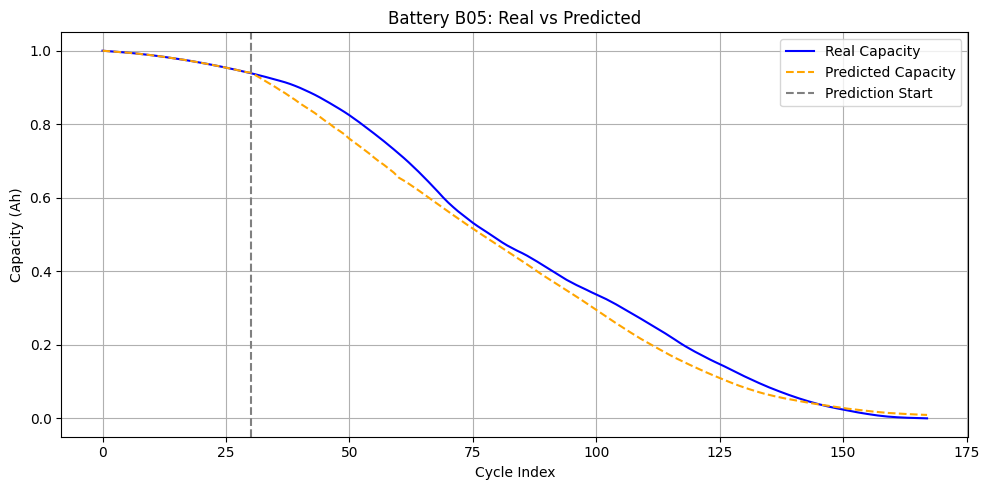

In [14]:
first_window_C = C_05[:30]
first_window_DVD = DVD_05[:30]#shape(30,)1d
first_window_ICA= ICA_05[:30]
first_window_CCCT= CCCT_05[:30]
first_window=np.stack([first_window_C,first_window_DVD,first_window_ICA,first_window_CCCT],axis=-1)#(30,4)
Tensor_test_B05 = torch.tensor(first_window.reshape(1, 30, 4), dtype=torch.float32)
label_b05 = df_raw.iloc[:, 0].values
def test():
    model_4to1 = LSTM(sequence_length=30, n_features=4, hidden_size=16, num_layers=2,model_type="4to1")
    model_4to1.load_state_dict(torch.load("finetuned_LSTM_4to1_B05.pth"))
    model_4to4 = LSTM(sequence_length=30, n_features=4, hidden_size=16, num_layers=2, model_type="4to4")
    model_4to4.load_state_dict(torch.load("best LSTM_4to4.pth"))
    model_4to4.eval()
    model_4to1.eval()
    with torch.no_grad():
        h_t,c_t=None,None
        sliding_prediction=[]
        for idx in range(500):
            if idx == 0:
                input_window = Tensor_test_B05
            else:
                y_add = y_pre_last_4to4[:, 0:1, :]  # [1,1,4]
                input_window = torch.cat([input_window[:, 1:, :], y_add], dim=1) #[1,30,4]
            
            y_pre_4to1,(h_t,c_t) = model_4to1(input_window,h_t,c_t)
            y_pre_4to4,(h_t,c_t) = model_4to4(input_window,h_t,c_t)
            y_pre_last_4to4 = y_pre_4to4.clone()
            h_t=h_t.detach()
            c_t=c_t.detach()

            if idx == 0:
                sliding_prediction.append(y_pre_4to1.detach().squeeze().tolist())
            else:
                sliding_prediction.append(y_pre_4to1.squeeze().tolist()[-1])

            if len(sliding_prediction)== 109: #because [30]+108
                break
        
        sliding_prediction=sliding_prediction[0]+sliding_prediction[1:]
        total=first_window_C.tolist()+sliding_prediction

    return sliding_prediction,total

sliding_prediction_B05,total_B05=test()
df = pd.read_csv('Models\Prediction_Results.csv')
df['Total_B05_TwinLstm'] = total_B05
#df.to_csv('B05_results.csv', index=False)
mae = mean_absolute_error(label_b05, total_B05)
rmse = np.sqrt(mean_squared_error(label_b05, total_B05))
r2 = r2_score(label_b05, total_B05)
print(f"Metric for test dataset B05: MAE={mae:.4f} | RMSE={rmse:.4f} | R²={r2:.4f}")
plt.figure(figsize=(10, 5))
plt.plot(range(168), label_b05, label="Real Capacity", color="b")
plt.plot(range(168), total_B05, label="Predicted Capacity", color="orange", linestyle='--')
plt.axvline(30, color='gray', linestyle='--', label='Prediction Start')
plt.xlabel("Cycle Index")
plt.ylabel("Capacity (Ah)")
plt.title("Battery B05: Real vs Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()